# Compute Principal Component Analysis

This notebook computes a Principal Component Analysis on the molecular descriptors previously computed.

## Initialization

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

# standard
from pathlib import Path
import sys
import warnings
# plot
import seaborn as sns
from matplotlib import pyplot as plt
# data
import pandas as pd
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# dev
PROJECT_DIR = list(Path("..").absolute().parents)[1]
sys.path.append(str(PROJECT_DIR))
import utils as u
Path("../tmp").mkdir(exist_ok=True)

/home/gally/Software/anaconda3/envs/rdkit/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Globals

In [2]:
# Dataset labels
label_inhouse = 'Pseudo-NPs'
label_drugbank = 'DrugBank'
label_chemblnp = 'ChEMBL-NP'
label_enamine = 'Enamine'

# input files
input_inhouse = './results/internal_desc.tsv.gz'
input_drugbank = './results/drugbank_desc.tsv.gz'
input_chemblnp = './results/chemblnp_desc.tsv.gz'
input_enamine = './results/enamine_desc.tsv.gz'


## Load data

In [3]:
# pseudo-NPs
df_inhouse = u.read_tsv(input_inhouse).rename({'Compound_Id': 'id'}, axis=1)
df_inhouse['dataset'] = label_inhouse
print(f"Loaded {len(df_inhouse):,} records for inhouse")

# DrugBank
df_drugbank = u.read_tsv(input_drugbank).rename({'DATABASE_ID': 'id'}, axis=1)
df_drugbank['dataset'] = label_drugbank
print(f"Loaded {len(df_drugbank):,} records for drugbank")

# ChEMBL-NP
df_chemblnp = u.read_tsv(input_chemblnp).rename({'chembl_id': 'id'}, axis=1)
df_chemblnp['dataset'] = label_chemblnp
print(f"Loaded {len(df_chemblnp):,} records for chemblnp")

# Enamine
df_enamine = u.read_tsv(input_enamine).rename({'idnumber': 'id'}, axis=1)
df_enamine['dataset'] = label_enamine
print(f"Loaded {len(df_enamine):,} records for chemblnp")

# concatenate all into a single DF
df = pd.concat([df_inhouse, df_chemblnp, df_drugbank, df_enamine], join='inner').reset_index(drop=True)  # reference needs to be first

Loaded 168 records for inhouse
Loaded 7,472 records for drugbank
Loaded 30,655 records for chemblnp
Loaded 49,968 records for chemblnp


### Check if some datasets overlap

In [4]:
df_overlap = df.groupby('Smiles').filter(lambda x: len(x) > 1)
df_overlap[['dataset', 'id']].groupby('dataset').count()

,id
dataset,
ChEMBL-NP,616
DrugBank,621
Enamine,7


There are 615 molecules that are present in both ChEMBL-NP and DrugBank datasets. This is not surprising since NPs can be drugs and should not require any curation.  

One molecule from ChEMBL-NP is also found in Enamine and 6 molecules from DrugBank are found in Enamine as well.

## Perform PCA

### Prepare data

In [5]:
# define features
annotations = ['id', 'Smiles', 'dataset']
labels = ['dataset', 'id']
features = [c for c in df.columns if c not in annotations]
num_features = len(features)

# extract features and labels
x = df.loc[:, features].values
y = df.loc[:, labels].values

# normalize features
x_norm = StandardScaler().fit_transform(x)

### Pick a number of Principal Components

/home/gally/Publications/Papers/2020_NatCommun_pseudo-NP/github/code_manuscript-main/utils.py:841: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


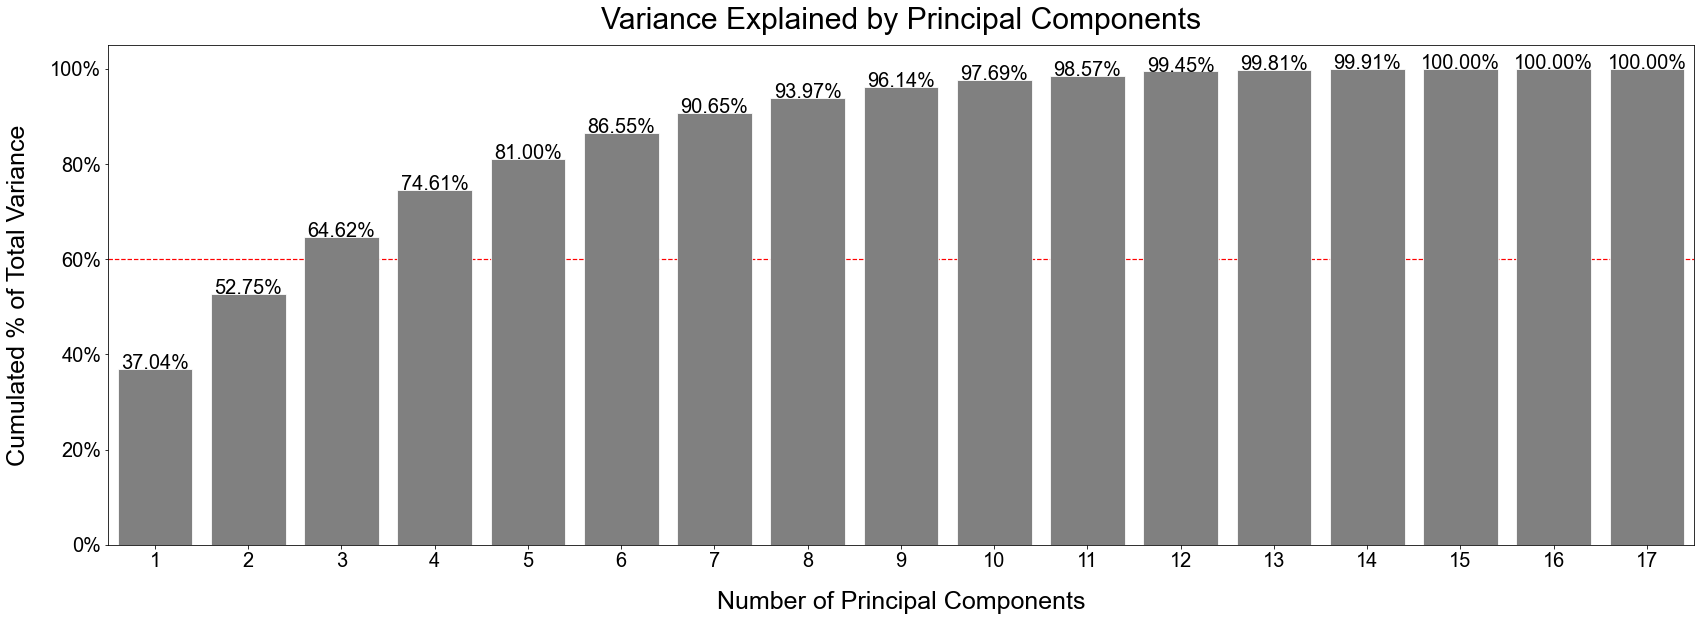

In [6]:
# initiate PCA with a dimension for each feature
pca_model = PCA(n_components=num_features)
# perform PCA
pca = pca_model.fit_transform(x_norm)
df_pca = pd.DataFrame(data = pca, columns = [f"PC{i+1}" for i in range(0, num_features)])
df_pca = df_pca.merge(df[labels], left_index=True, right_index=True)
df_pca_var = u.get_pca_var(pca_model)
u.write_tsv(df_pca_var, 'results/pca_var.tsv.gz')


fig = u.plot_pca_var(df_pca_var)
fig.savefig('plots/pca_var.png', dpi=600)

More than 60% of the total variance of the data is retained with the first three Principal Components. Therefore these will be used for the rest of the study.

### Perform PCA with 3 Principal Components

In [7]:
# run pca with 3 components
pca_model = PCA(n_components=3)
pca = pca_model.fit_transform(x_norm)

df_pca = pd.DataFrame(data = pca, columns = ['PC1', 'PC2', 'PC3'])
df_pca = df_pca.merge(df[labels], left_index=True, right_index=True)# .sort_values('dataset', ascending=True)
display(df_pca)

,PC1,PC2,PC3,dataset,id
0,1.198517,-1.475045,3.215964,Pseudo-NPs,408580
1,1.924482,-1.532750,3.588236,Pseudo-NPs,408614
2,1.308144,-1.449243,3.532906,Pseudo-NPs,409679
3,1.235020,-1.386378,3.424079,Pseudo-NPs,408605
4,1.759038,-1.355780,3.125099,Pseudo-NPs,408610
...,...,...,...,...,...
88258,-0.277847,-0.785993,-0.162869,Enamine,Z4783341239
88259,-1.207776,0.312304,0.427388,Enamine,Z2169314532
88260,-0.890394,1.264326,1.356251,Enamine,Z2706351018
88261,-1.813089,-0.632618,-3.216415,Enamine,Z4188207289


By considering the first three PC, we can explain approx. 2/3 of the data variance. 

### Investigate feature contribution

In [9]:
df_pca_feature_contrib = u.get_pca_feature_contrib(pca_model, features)
u.write_tsv(df_pca_feature_contrib, 'results/pca_feature_contrib.tsv.gz')
df_pca_feature_contrib

,Feature,PC1_feature_contrib,PC2_feature_contrib,PC3_feature_contrib,PC1_rank,PC2_rank,PC3_rank,PC1_feature_contrib_cum_ratio,PC2_feature_contrib_cum_ratio,PC3_feature_contrib_cum_ratio
0,frac_sp3,0.084178,0.406489,0.320259,14,2,4,0.973634,0.254949,0.471941
1,molecular_weight,0.367527,0.018352,0.164075,2,17,9,0.205545,1.000000,0.753726
2,num_atoms_bridgehead,0.143249,0.225228,0.141049,12,7,11,0.923849,0.688095,0.835963
3,num_atoms_halogen,0.058925,0.098341,0.122399,15,13,15,0.990110,0.966009,0.986156
4,num_atoms_nitrogen,0.033127,0.366111,0.143801,16,4,10,0.999373,0.481649,0.795242
5,num_atoms_oxygen,0.335731,0.022232,0.136077,4,16,12,0.393501,0.994594,0.875249
6,num_hba,0.320416,0.249445,0.032904,6,5,16,0.573813,0.555129,0.995656
7,num_hbd,0.220766,0.196390,0.233048,8,9,5,0.720089,0.810825,0.539223
8,num_heavy_atoms,0.367558,0.031393,0.188885,1,15,7,0.102777,0.988045,0.652230
9,num_rings,0.189120,0.173573,0.503667,10,10,1,0.832947,0.861955,0.145410


/home/gally/Publications/Papers/2020_NatCommun_pseudo-NP/github/code_manuscript-main/utils.py:1007: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(yticklabels)


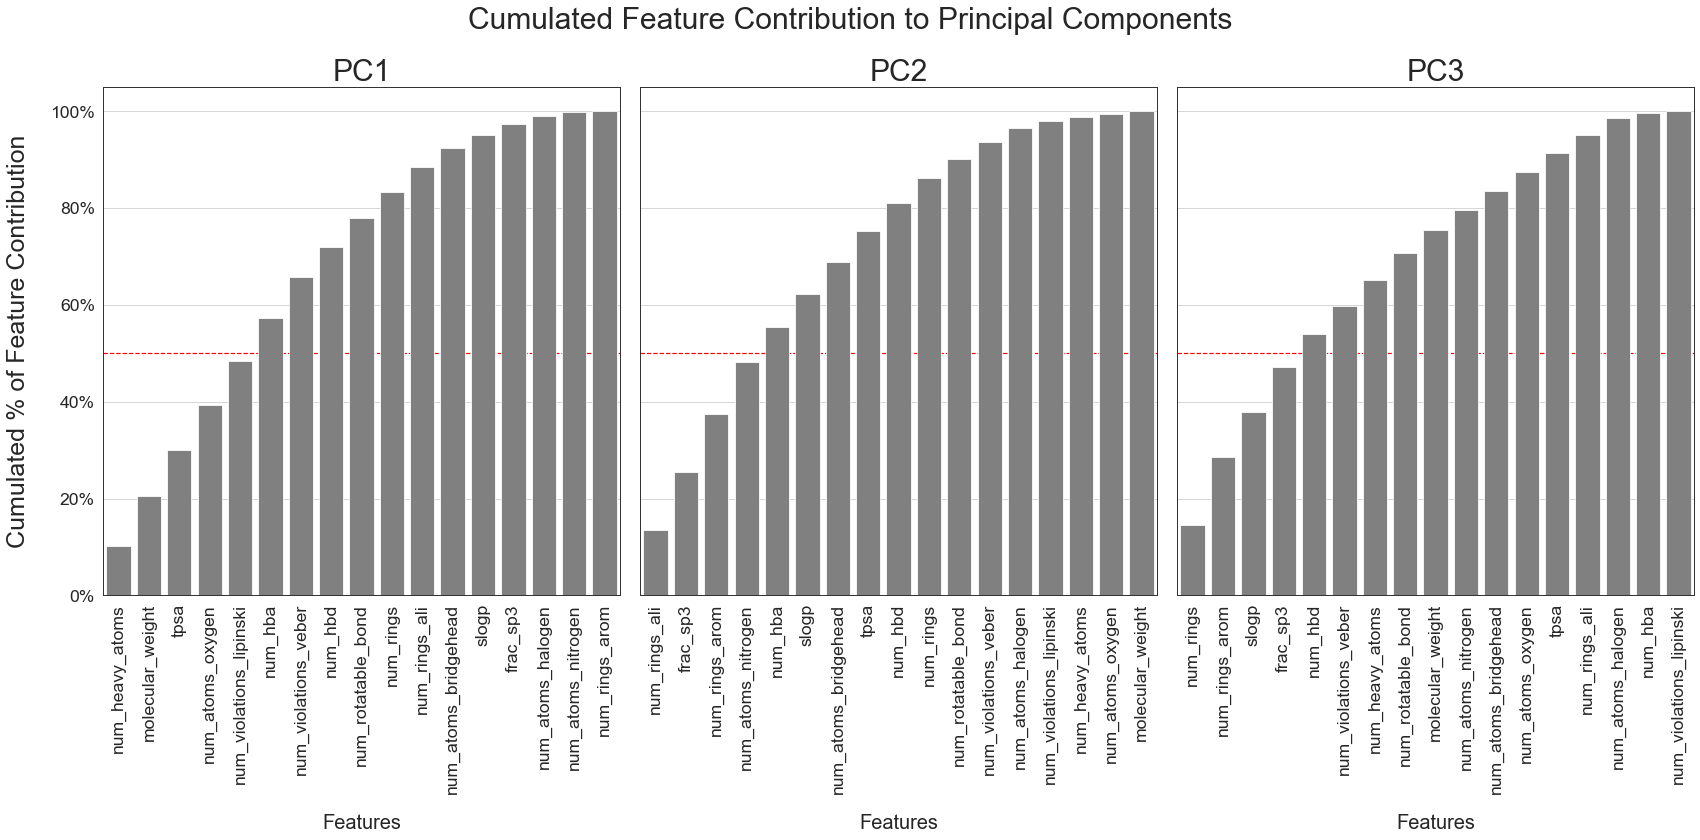

In [10]:
fig = u.plot_pca_cum_feature_contrib_3pc(df_pca_feature_contrib)
fig.savefig('plots/pca_cum_feature_contrib.png', dpi=600)

In [11]:
df_pca_feature_contrib_form = u.format_pca_feature_contrib(df_pca_feature_contrib)
u.write_tsv(df_pca_feature_contrib_form, 'results/pc_feature_contrib_form.tsv.gz')
print("Three Most contributing features are:")
display(df_pca_feature_contrib_form[df_pca_feature_contrib_form['Rank'] < 4][['PC', 'Feature']].reset_index(drop=True))

Three Most contributing features are:


,PC,Feature
0,PC1,molecular_weight
1,PC1,num_heavy_atoms
2,PC1,tpsa
3,PC2,frac_sp3
4,PC2,num_rings_ali
5,PC2,num_rings_arom
6,PC3,num_rings
7,PC3,num_rings_arom
8,PC3,slogp


/home/gally/Software/anaconda3/envs/rdkit/lib/python3.8/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2304x864 with 0 Axes>

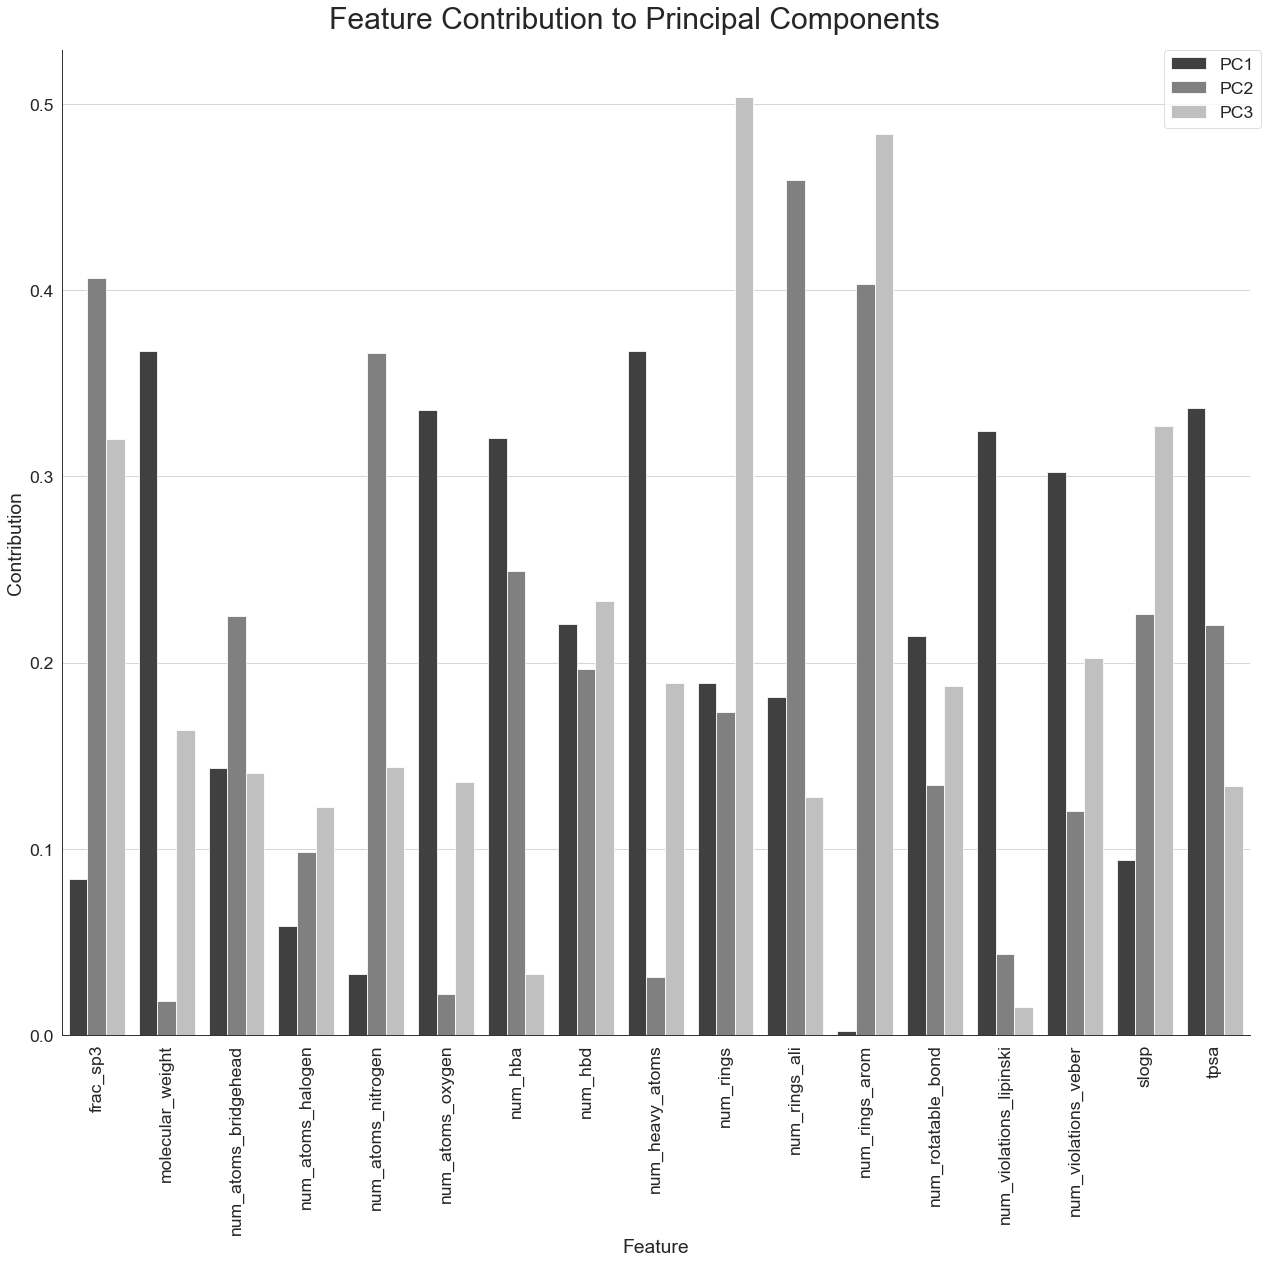

In [12]:
fig = u.plot_pca_feature_contrib(df_pca_feature_contrib_form)
fig.savefig('plots/pca_feature_contrib_norm.png', dpi=600)

### Component Loading

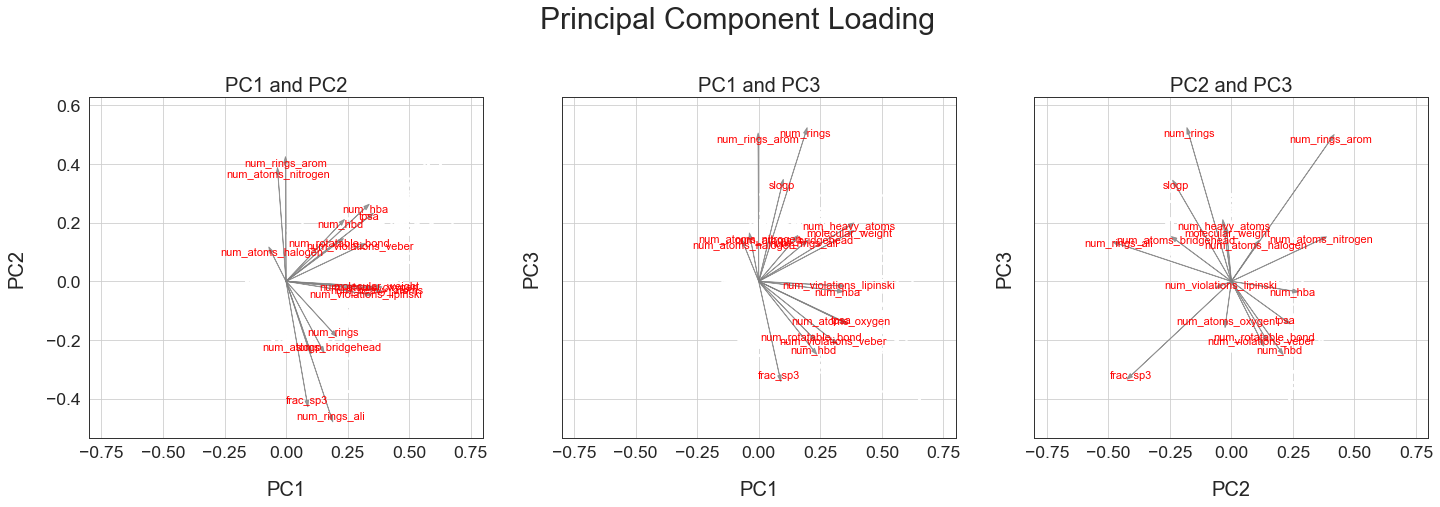

In [13]:
fig = u.plot_pca_loadings_3pc(pca_model, pca, features)
fig.savefig('plots/pca_component_loading.png', dpi=600)

### Plot PCA

In [16]:
df_pca = df_pca.rename({'dataset': 'Dataset'}, axis=1)

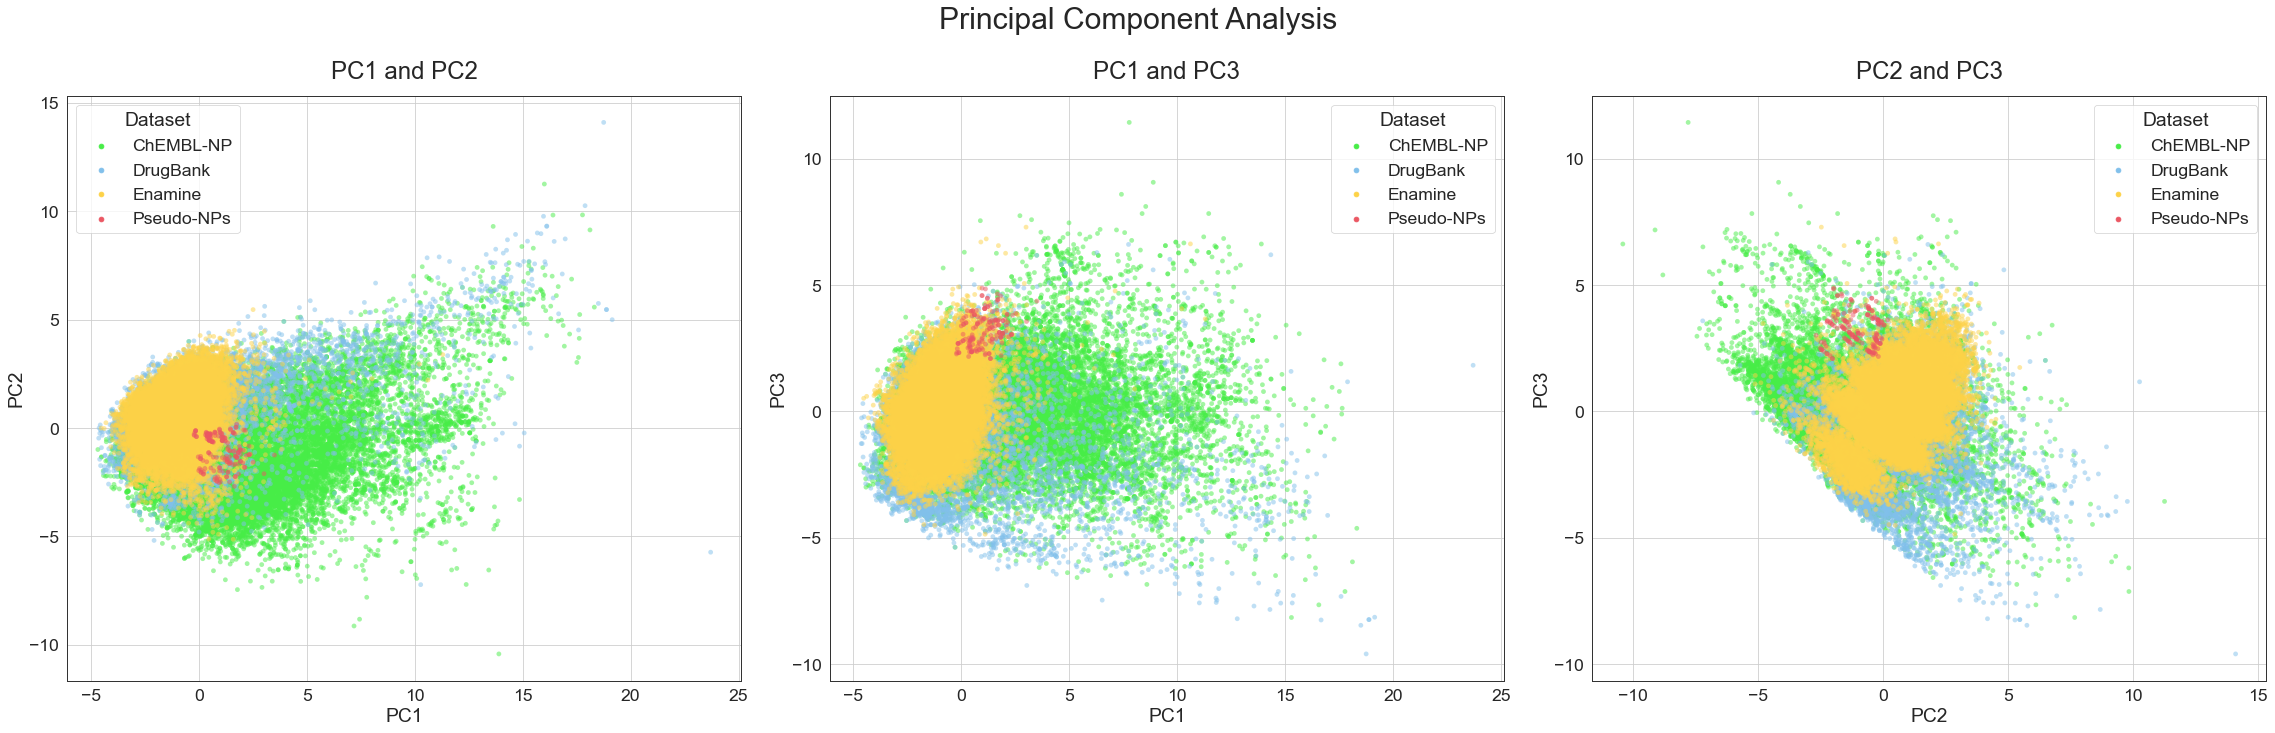

In [17]:
palette = [
           "#47ED47",  # green
           "#81C0EB",  # blue
           "#FDD247",  # orange
           "#EB5763",  # red
          ]
fig = u.plot_pc_proj(df_pca, palette=palette)
fig.savefig('plots/pca_proj.png', dpi=300)

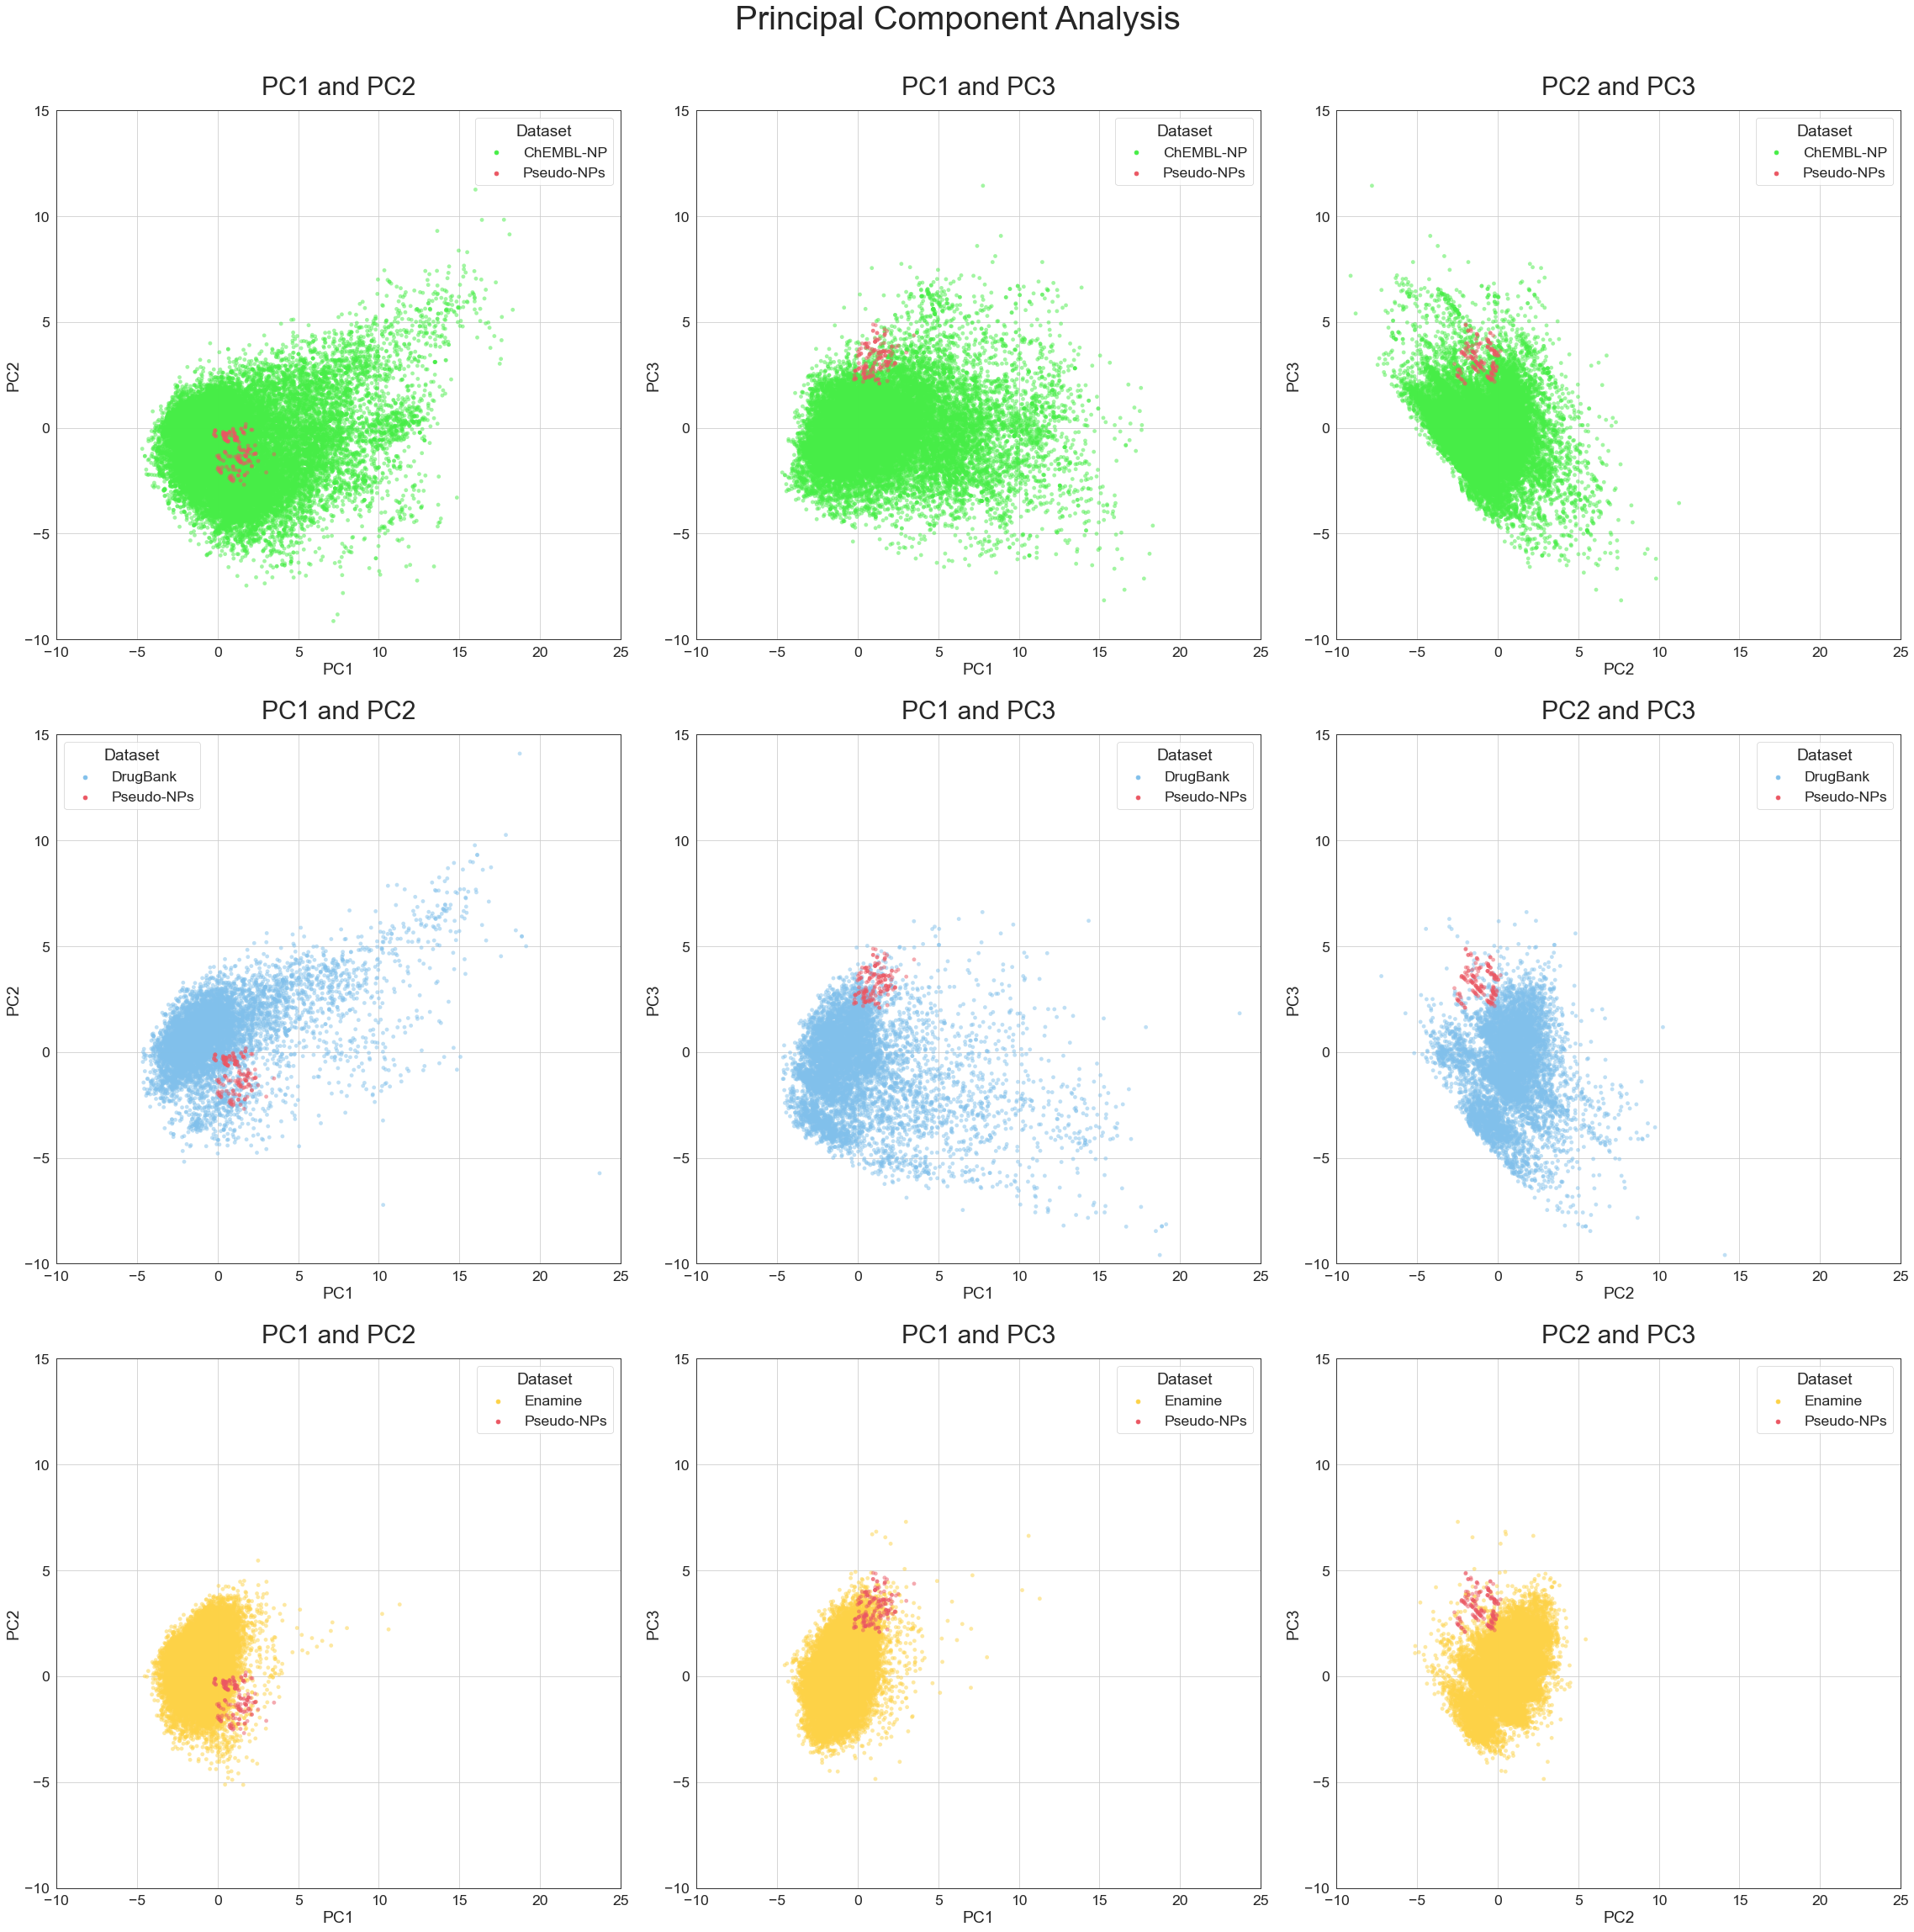

In [18]:
df_pca = df_pca.rename({'dataset': 'Dataset'}, axis=1)
fig = u.plot_pc_proj_with_ref(df_pca, 'Pseudo-NPs')
fig.savefig('plots/pca_proj_pairs.png', dpi=300)  # file is too large with dpi=600